# Age Gender Predictor - Jonathan Chua
This model is a fine tuned EfficientNetB4 model that predicts the age and gender of social media images of a face of size 150 by 150 pixels with a multi-output model. It is built on pytorch and trained on a dataset of over 100,000 faces.

As the faces in the images are of different sizes and proximity to the camera, the RetinaFace detector is used to detect and crop out the faces present in the image. These cropped face images are then used to fine-tune the EfficientNetB4 model which has the ImageNet weights pre-loaded onto it.

# Training and Validation

Steps in training:
1. Install and import Efficient Net, which will be used as the pre-trained model for transfer learning
2. Define functions to (a) load data, (b) load modified model, (c) save weights, (d) train model, and (e) validate model
3. Download csv paths of images and create dataset
4. Train model for 60 epochs

## Install and Imports

In [ ]:
!pip install --upgrade efficientnet-pytorch
!pip install torchvision
!pip install opencv-python
!pip install tensorflow

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os,sys
from torch.utils import data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, TensorDataset
from PIL import Image
import matplotlib.pyplot as plt
from autoaugment import ImageNetPolicy
from efficientnet_pytorch import EfficientNet

import time
import math

import warnings
warnings.simplefilter("ignore")

In [ ]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)

Function to use to visualise images based on the image path

In [ ]:
def show_from_path(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

## Prepare Datasets

In [ ]:
final_df = pd.read_csv('age_gender_detected.csv')
train_df, test_df = train_test_split(final_df, test_size=0.01, random_state=42)

Test df

In [7]:
print(test_df.shape)
test_df.head()

(1041, 3)


,Path,age,gender
0,final_train_test_data/no_face_detected/image_5...,M,63
1,final_train_test_data/no_face_detected/image_2...,M,36
2,final_train_test_data/no_face_detected/image_5...,F,7
3,final_train_test_data/no_face_detected/image_1...,M,48
4,final_train_test_data/no_face_detected/image_7...,F,48


Train df

In [ ]:
print(train_df.shape)
train_df.head()

(105374, 3)


,path,age,gender
0,final_train_test_data/face_detected/image_2219...,60,M
1,final_train_test_data/face_detected/image_9203...,25,M
2,final_train_test_data/face_detected/image_5164...,30,M
3,final_train_test_data/face_detected/image_2389...,18,M
4,final_train_test_data/face_detected/image_6845...,31,F


Visualise train-val data

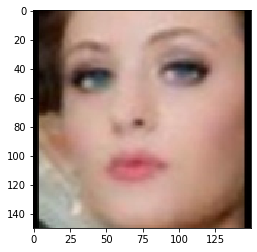

In [ ]:
show_from_path(train_df['path'].iloc[np.random.randint(100000)])

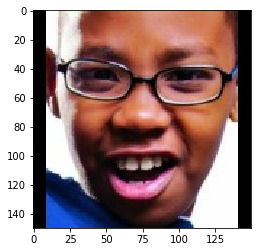

In [ ]:
show_from_path(train_df['path'].iloc[np.random.randint(100000)])

## Train Model

Load dataset via the Dataloader class

In [ ]:
def loaddata(df):
    X = df["path"].values
    age = df["age"].values
    gender = df["gender"].values
    gender = pd.get_dummies(gender).values

    X_train, X_test, age_train, age_test, gender_train, gender_test = train_test_split(X, age, gender, test_size=0.2, random_state=42)
    print(X_train.shape, X_test.shape, age_train.shape, age_test.shape, gender_train.shape, gender_test.shape)
    
    
    train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(150),
                                           transforms.RandomHorizontalFlip(),
                                           ImageNetPolicy(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    test_transforms = transforms.Compose([transforms.Resize(150),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


    class MyDataset(Dataset):
        def __init__(self, tensors, transform=None):
            self.tensors = tensors
            self.transform = transform

        def __getitem__(self, index):
            imgpath = self.tensors[0][index]
            img = cv2.imread(imgpath)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(150,150))
            img = img.astype('float32')
            img = Image.fromarray(img.astype(np.uint8))
            if self.transform:
                img = self.transform(img)

            age = self.tensors[1][index]
            age = age.astype("float32")
            gender = self.tensors[2][index]
            gender = gender.astype("float32")
            return img, age, gender

        def __len__(self):
            return len(self.tensors[0])

    train_data = MyDataset([X_train, age_train, gender_train], transform = train_transforms)
    test_data = MyDataset([X_test, age_test, gender_test], transform = test_transforms)

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=0)
    
    return trainloader, testloader

Create a multi-output model for age and gender

In [ ]:
def loadmodel(device):
    effNet = EfficientNet.from_pretrained('efficientnet-b4')
    effNet._fc = nn.Identity()
    effNet._swish = nn.Identity()

    class multiOutputModel(nn.Module):
        def __init__(self, effNet):
            super(multiOutputModel, self).__init__()
            self.effNet = effNet
            self.age = nn.Linear(1792, 1)
            self.gender = nn.Linear(1792, 2)

        def forward(self, inputs):
            x = self.effNet(inputs)
            age_out = self.age(x)
            gender_out = self.gender(x)
            return age_out, gender_out

    net = multiOutputModel(effNet)
    net = net.to(device)
    return net

Train and validation functions + save weights function

In [ ]:
def saveweights(net, modelname, savedir):
    
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
    
    torch.save(net.state_dict(), f'{savedir}/{modelname}.pth')
    
    
    
def train(n_epochs, device, modelname, savedir, df):
    
    trainloader, testloader = loaddata(df)
    net = loadmodel(device)
    
    best_loss = 200
    start_epoch = 0
    
    gender_criterion = nn.BCEWithLogitsLoss()
    age_criterion = nn.MSELoss()
    optimizer=optim.Adam(net.parameters(), lr=0.002)
    scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, threshold=0.01, verbose=True)
    
   
    for epoch in range(n_epochs):
        print('\nEpoch: %d' % epoch)
        current_lr = optimizer.param_groups[0]['lr']
        print('current lr: {}'.format(current_lr))
        net.train()
        
        age_loss = 0
        gender_loss = 0
        train_loss = 0
        gender_correct = 0
        total = 0
        
        age_preds = []
        age_gt = []
        
        for batch_idx, (inputs, age_targets, gender_targets) in enumerate(tqdm(trainloader)):
            inputs, age_targets, gender_targets = inputs.to(device), age_targets.to(device), gender_targets.to(device)
            optimizer.zero_grad()
            age_out, gender_out = net(inputs)
            
            age_targets = age_targets.reshape(-1,1)
            loss_1 = age_criterion(age_out, age_targets)
            loss_2 = gender_criterion(gender_out, gender_targets)
            loss = loss_1 * loss_2
            loss.backward()
            optimizer.step()
            age_loss += loss_1.item()
            gender_loss += loss_2.item()
            train_loss += loss.item()
            
            age_preds.append(age_out.cpu().detach().numpy().tolist())
            age_gt.append(age_targets.cpu().detach().numpy().tolist())

            _, gender_pred = gender_out.max(1)
            total += inputs.size(0)
            gender_correct += gender_pred.eq(gender_targets.max(1)[-1]).sum().item()
            gender_acc = 100.*gender_correct/total            

            print(f"gender_acc: {round(gender_acc, 2)}% | train_loss: {round(train_loss/(batch_idx+1), 4)} | gender_correct/total: {gender_correct}/{total}", end="\r")
        
        print(f"age_loss: {round(age_loss/(batch_idx+1), 4)}")
        print(f"gender_loss: {round(gender_loss/(batch_idx+1), 4)}")
        
        age_preds = np.concatenate(np.array(age_preds), axis=0)
        age_gt = np.concatenate(np.array(age_gt), axis=0)
        diff = age_preds - age_gt
        train_age_mae = np.abs(diff).mean()
        
        test_age_mae, test_gender_acc, test_loss = test(epoch, testloader, device, net, age_criterion, gender_criterion)

        scheduler.step(test_loss)
        # Save checkpoint.
        if test_loss < best_loss:
            print('Saving model now !!!!!!!!!!!!!!!!!!!!!!!')
            saveweights(net, modelname, savedir)
            best_loss = test_loss
        else:
            print ('Model did not improve')
        
        print('epoch: {} | train gender acc: {}% | test gender acc: {}% | train age mae: {} | test age mae: {} | train loss: {} | test loss: {}'.format(epoch, gender_acc, test_gender_acc, train_age_mae, test_age_mae, round(train_loss/(batch_idx+1),4), test_loss))
        print('\n==============================================================================================\n')



# for validation
def test(epoch, dataloader, device, net, age_criterion, gender_criterion):
    age_preds = []
    age_gt = []
    net.eval()
    test_loss = 0
    age_correct = 0
    gender_correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, age_targets, gender_targets) in enumerate(tqdm(dataloader)):
            inputs, age_targets, gender_targets = inputs.to(device), age_targets.to(device), gender_targets.to(device)
            age_out, gender_out = net(inputs)
            
            age_targets = age_targets.reshape(-1,1)
            loss_1 = age_criterion(age_out, age_targets)
            loss_2 = gender_criterion(gender_out, gender_targets)
            loss = loss_1 * loss_2
            test_loss += loss.item()
            
            age_preds.append(age_out.cpu().detach().numpy().tolist())
            age_gt.append(age_targets.cpu().detach().numpy().tolist())
        
            _, gender_pred = gender_out.max(1)
            total += inputs.size(0)
            gender_correct += gender_pred.eq(gender_targets.max(1)[-1]).sum().item()
            test_gender_acc = 100.*gender_correct/total 

    age_preds = np.concatenate(np.array(age_preds), axis=0)
    age_gt = np.concatenate(np.array(age_gt), axis=0)
    diff = age_preds - age_gt
    test_age_mae = np.abs(diff).mean()
    
    return test_age_mae, test_gender_acc, test_loss/(batch_idx+1)

Train model for 60 epochs
Best score:
1. epoch: 50
2. train gender acc: 95.89556222493742%
3. test gender acc: 98.07829181494662%
4. train age mae: 5.3441311435778145
5. test age mae: 4.396208475114046
6. train loss: 5.1844
7. test loss: 2.225243363847422

In [ ]:
# All seeds = 42

n_epochs = 60
device = "cuda"
savedir = "model_weights"
df = train_df
modelname = 'fast_model_b4_full_dataset'

train(n_epochs, device, modelname, savedir, train_df)

# Prediction on out-of-sample test set

Steps for prediction:
1. Define functions to (a) load modified model and (b) make prediction on single sample
2. Run predictions and check results

## Functions

In [ ]:
def load_model(modelname):
    effNet = EfficientNet.from_pretrained('efficientnet-b4')
    effNet._fc = nn.Identity()
    effNet._swish = nn.Identity()

    class multiOutputModel(nn.Module):
        def __init__(self, effNet):
            super(multiOutputModel, self).__init__()
            self.effNet = effNet
            self.age = nn.Linear(1792, 1)
            self.gender = nn.Linear(1792, 2)

        def forward(self, inputs):
            x = self.effNet(inputs)
            age_out = self.age(x)
            gender_out = self.gender(x)
            return age_out, gender_out

    net = multiOutputModel(effNet)
    
    modelweights = torch.load(f'model_weights/{modelname}.pth', map_location = "cpu")
    net.load_state_dict(modelweights)
    return net

In [ ]:
def getage(img_arr, modelname, device):
    
    test_transforms = transforms.Compose([transforms.Resize(150),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    class MyDataset(Dataset):
        """TensorDataset with support of transforms.
        """
        def __init__(self, tensors, transform=None):
            self.tensors = tensors
            self.transform = transform

        def __getitem__(self, index):
            img = self.tensors[index]
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(150,150))
            img = img.astype('float32')
            img = Image.fromarray(img.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
            return img

        def __len__(self):
            return len(self.tensors)
    
    test_data = MyDataset(img_arr, transform = test_transforms)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=1)
    
    net = load_model(modelname).to(device)
    net.eval()
    
    age_preds = []
    gender_preds = []
    with torch.no_grad():
        for batch_idx, inputs in enumerate(testloader):
            inputs = inputs.to(device)
            age_out, gender_out = net(inputs)
            
            age_preds.extend(age_out.cpu().detach().numpy()) 
            _, gender_predicted = gender_out.max(1)
            gender_preds.extend(gender_predicted.tolist())
    
    age_preds = list(np.concatenate(np.array(age_preds), axis=0))
    gender_preds = ['F' if i is not 1 else 'M' for i in gender_preds]

    return {'age': age_preds, 'gender': gender_preds}

In [ ]:
def age_prediction(path_array, modelname, device):
    face_array = []
    for imgpath in path_array:
        face = cv2.imread(imgpath)
        face_array.append(face)

    result = getage(face_array, modelname, device)
    return result

## Test Samples

In [ ]:
path_array = test_df['path'].values
modelname = "fast_model_b4_full_dataset"
device = "cpu"
result = age_prediction(path_array, modelname, device)

Loaded pretrained weights for efficientnet-b4


In [ ]:
test_df['predicted_age'] = result['age']
test_df['mae'] = test_df.apply(lambda row: np.abs(row['age'] - row['predicted_age']), axis=1)
test_df['predicted_gender'] = result['gender']

def get_gender_accuracy(row):
    if row['gender'] == row['predicted_gender']:
        return 1
    return 0
    
test_df['correct_gender'] = test_df.apply(lambda row: get_gender_accuracy(row), axis=1)

In [ ]:
print(f"Age MAE: {test_df['mae'].mean()}")
print(f"Gender Percentage: {test_df['correct_gender'].mean()*100}")

Age MAE: 4.842052759056934
Gender Percentage: 96.82997118155619


In [ ]:
test_df['mae'].describe()

count    1041.000000
mean     4.842053   
std      4.285280   
min      0.002104   
25%      1.749401   
50%      3.709698   
75%      6.787689   
max      38.494637  
Name: mae, dtype: float64

In [ ]:
test_df.head(25)

,path,age,gender,predicted_age,mae,predicted_gender,correct_gender
468,final_train_test_data/face_detected/image_469.jpg,49,M,38.630478,10.369522,M,1
3219,final_train_test_data/face_detected/image_3220.jpg,33,F,31.587326,1.412674,F,1
538,final_train_test_data/face_detected/image_539.jpg,56,M,54.894428,1.105572,M,1
4691,final_train_test_data/face_detected/image_4692.jpg,26,M,26.790018,0.790018,M,1
6384,final_train_test_data/face_detected/image_6385.jpg,24,F,25.917585,1.917585,F,1
7731,final_train_test_data/face_detected/image_7732.jpg,7,M,10.654798,3.654798,M,1
1883,final_train_test_data/face_detected/image_1884.jpg,36,M,28.756393,7.243607,M,1
11397,final_train_test_data/face_detected/image_11398.jpg,47,M,46.341084,0.658916,M,1
7113,final_train_test_data/face_detected/image_7114.jpg,1,M,0.305964,0.694036,M,1
7306,final_train_test_data/face_detected/image_7307.jpg,4,M,6.026610,2.026610,F,0


Visualise Poor Predictions

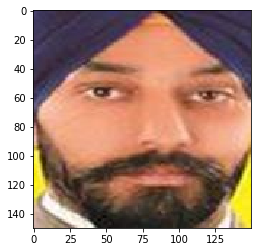

predicted: 38.63
actual: 49


In [ ]:
sample = test_df.loc[468]
show_from_path(sample['path'])
print(f'predicted: {round(sample["predicted_age"], 2)}')
print(f'actual: {sample["age"]}')

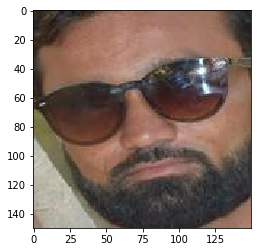

predicted: 35.94
actual: 25


In [ ]:
sample = test_df.loc[2464]
show_from_path(sample['path'])
print(f'predicted: {round(sample["predicted_age"], 2)}')
print(f'actual: {sample["age"]}')

Visualise good prediction

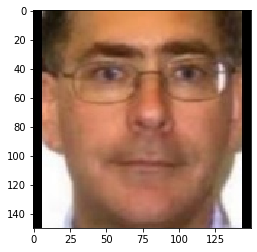

predicted: 46.34
actual: 47


In [ ]:
sample = test_df.loc[11397]
show_from_path(sample['path'])
print(f'predicted: {round(sample["predicted_age"], 2)}')
print(f'actual: {sample["age"]}')